# Clustering analysis on lateral and medial parafacial cells of the rat brain stem
**This notebook is divided into 4 sections:**
1. Generating an annotated data object from the raw data
2. Filtering data points and performing a clustering analysis
3. Identifying cell types by marker genes
4. Selecting neurons and performing a reclustering analysis

## 1: Generating the annotated data object (adata)

In [20]:
from os import chdir

chdir('/sc/service/analysis/tmp/rat_neuron_clustering_analysis')

from pathlib import Path
import scanpy as sc
import scrublet as scr
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
from warnings import filterwarnings
import sc_utils
import pandas as pd
import numpy as np

# Settings
filterwarnings('ignore')
sc.settings.verbosity = 0
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [21]:
# Read in annotated rat genes as pandas.DataFrame, see create_gene_annotations.py for annotation strategy
biomart_genes = pd.read_csv('reference_data/biomart_rat_genes.csv', index_col=0)
biomart_genes.head()

,Gene description,Gene name,Chromosome/scaffold name,mitochondrial,hemoglobin,sex_linked,canonical_neuronal,glutamatergic
ENSRNOG00000066169,NaN,NaN,1,False,False,False,False,False
ENSRNOG00000064641,NaN,NaN,4,False,False,False,False,False
ENSRNOG00000033395,olfactory receptor 473 [Source:RGD Symbol;Acc:...,Olr473,3,False,False,False,False,False
ENSRNOG00000066660,NaN,NaN,3,False,False,False,False,False
ENSRNOG00000070168,olfactory receptor 56 [Source:RGD Symbol;Acc:1...,Olr56,1,False,False,False,False,False


In [22]:
# Set directories for raw data
parent_directory = Path('/sc/service/tmp/archive-retreival')
adatas = {
    p.parents[1].name.split('_')[1].lower(): sc.read_10x_h5(p)
    for p in parent_directory.rglob('filtered*feature*matrix*.h5')
}

# Define a list of annotated genes
gene_types = [
    gene_type
    for gene_type in biomart_genes.columns
    if biomart_genes[gene_type].dtype == bool
]

for adata in adatas.values():
    # Annotate doublets. Better to do this before merging data than after
    # See https://github.com/swolock/scrublet#best-practices
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata.obs['doublet_score'] = doublet_scores
    adata.obs['doublet_predicted'] = predicted_doublets

    # Make var/obs names unique for concatenation
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

# Concatenate the two anndata objects
adata = ad.concat(adatas, merge='first', label='dataset')
adata.var = adata.var.join(biomart_genes[gene_types], on='gene_ids', how='left').copy()

# Delete variables that won't be used
del adatas, parent_directory

# Make variable/observation names unique again
adata.var_names_make_unique()
adata.obs_names_make_unique()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 66.7%
Elapsed time: 34.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.8%
Elapsed time: 13.6 seconds


In [23]:
# Calculate scanpy's quality control metrics for these gene types and save for later access
sc.pp.calculate_qc_metrics(adata, qc_vars=gene_types, inplace=True)
sc.write('write/composite_adata.h5ad', adata)

## 2: Filtering and clustering the annotated data object

In [24]:
print(
    f'The unfiltered annotated data object has {adata.n_vars} genes measured over {adata.n_obs} cells.'
)

The unfiltered annotated data object has 23096 genes measured over 28682 cells.


To clean up the data, all of the following will be removed:
- genes expressed in less than 5 cells
- genes with less than 10 counts (meaning they have less than 10 associated RNA transcripts in the whole dataset)
- cells that express less than 800 genes
- cells for which more than 15% of total expression is due to mitochondrial genes
- cells with more than 5 RNA transcripts coming from hemoglobin genes
- cells whose doublet score (as calculated by scublet) is more than 0.5

In [25]:
# Subset the adata object by selecting cells with the aforementioned criteria
adata = adata[
    (adata.obs['pct_counts_mitochondrial'] < 15)
    & (adata.obs['total_counts_hemoglobin'] < 5)
    & (adata.obs['doublet_score'] < 0.5)
]

# Filter this subset according to minima established above
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata, min_genes=800)

print(
    f'After filtering, there are {adata.n_vars} genes measured over {adata.n_obs} cells.'
)

After filtering, there are 15622 genes measured over 8092 cells.


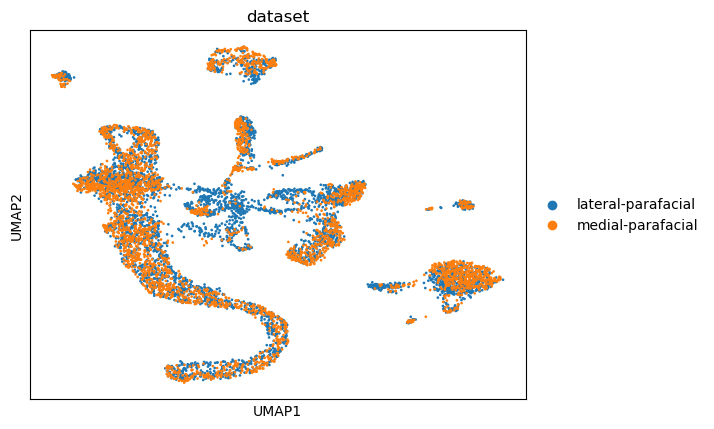

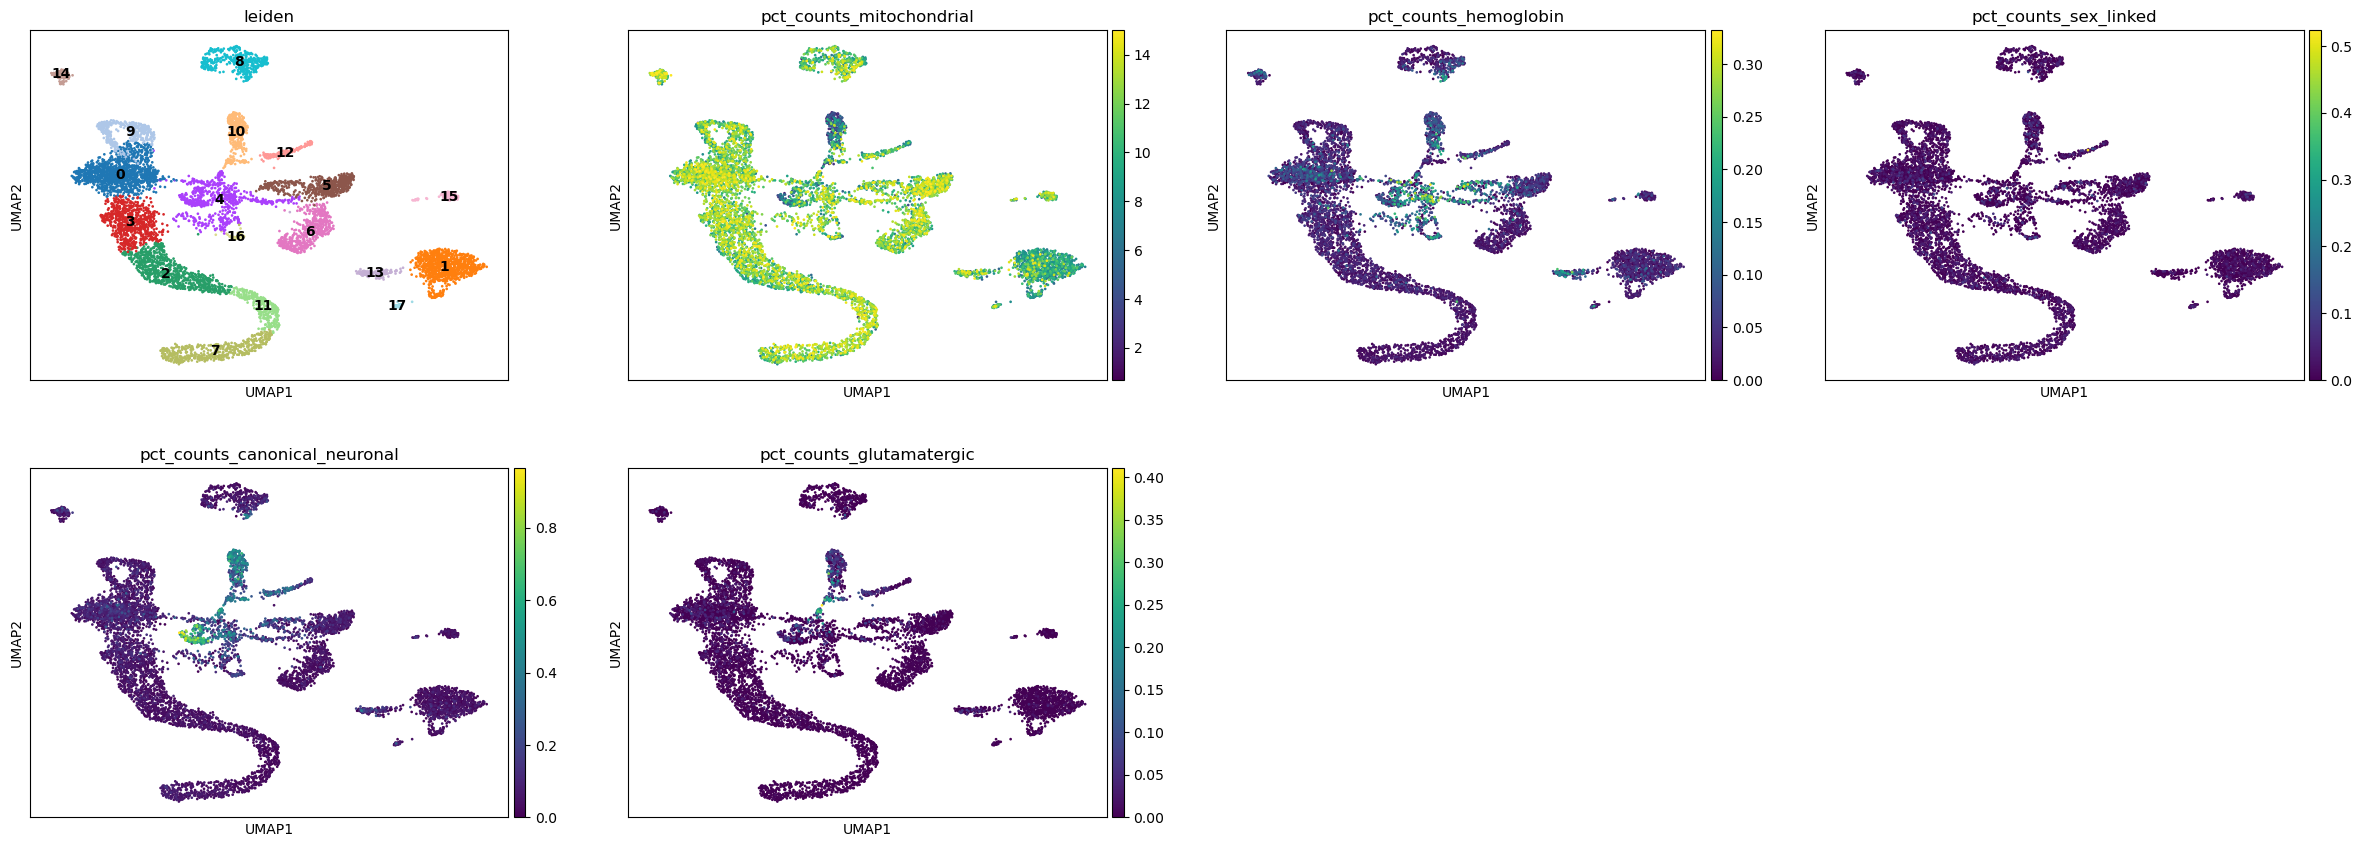

In [26]:
# Define a list of keys to plot
obs_keys_legend_on_data = ['leiden'] + [
    f'pct_counts_{gene_type}' for gene_type in gene_types
]
obs_keys_legend_off_data = ['dataset']

# Define a list of gene_types to exclude from PCA
not_highly_variable = [
    gene_type
    for gene_type in gene_types
    if 'neuronal' not in gene_type and 'glutamatergic' not in gene_type
]

adata = sc_utils.cluster_anndata(
    adata=adata,
    not_highly_variable=not_highly_variable,
    n_neighbors=30,
    n_pcs=30,
    leiden_resolution=0.5,
    obs_keys_legend_on_data=obs_keys_legend_on_data,
    obs_keys_legend_off_data=obs_keys_legend_off_data,
)

In [27]:
# Write object for later access
sc.write('write/adata_filtered_and_clustered.h5ad', adata)

## 3: Identifying cell types by finding marker genes

In [28]:
# Get the panglaodb.se links to determine cell type
adata = sc_utils.find_marker_genes(adata=adata)
# Run 'cell_typing.py' after this to facilitate getting cell types from panglao.db

In [29]:
# Based on pangloadb.se's results, assign a cell type to each cluster
# Note that macrophages (as identified by panglaodb.se) were labelled as microglia due to being in the brain
cell_types = {
    '0': 'OPC',
    '1': 'microglia',
    '10': 'neuron',
    '11': 'oligodendrocyte',
    '12': 'retinal_ganlgion',
    '13': 'microglia',
    '14': 'pericyte',
    '15': 'fibroblast',
    '16': 'oligodendrocyte',
    '17': 'microglia',
    '2': 'oligodendrocyte',
    '3': 'OPC',
    '4': 'neuron',
    '5': 'astrocyte',
    '6': 'astrocyte',
    '7': 'oligodendrocyte',
    '8': 'unknown',
    '9': 'unknown',
}

# Assign a cell type to each cluster
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_types)

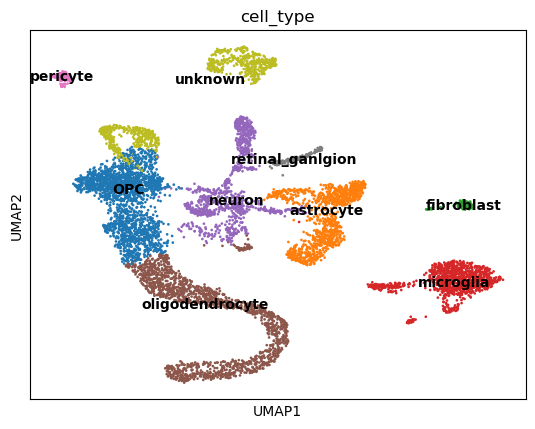

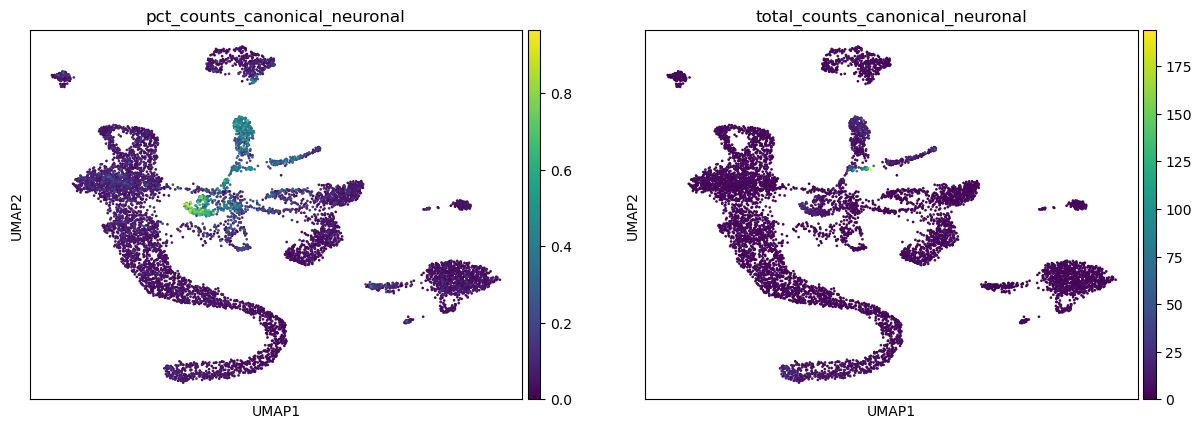

In [30]:
# Plot cell types and canonical neuronal genes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data')
sc.pl.umap(
    adata, color=['pct_counts_canonical_neuronal', 'total_counts_canonical_neuronal']
)

In [31]:
# Write object for later access
sc.write('write/adata_cell_types_identified.h5ad', adata)

## 4: Selecting only the neurons

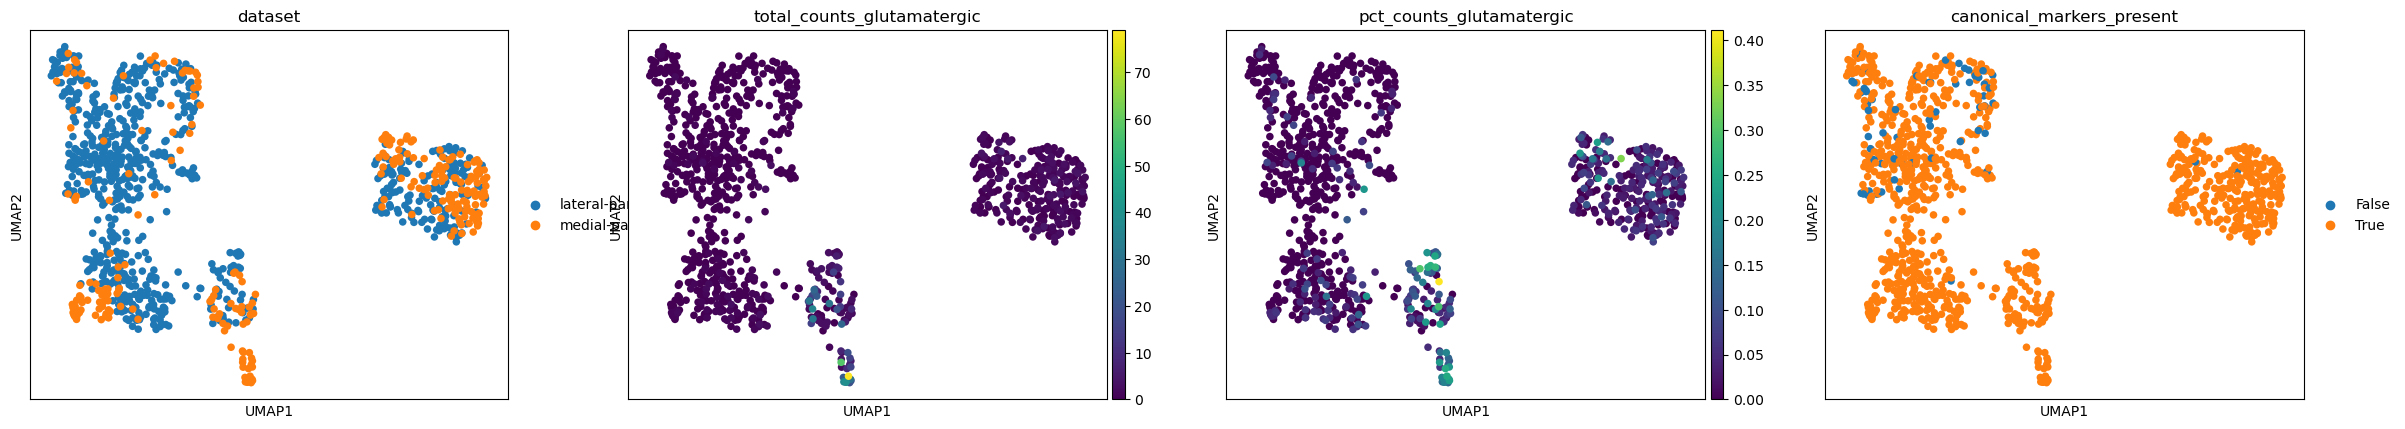

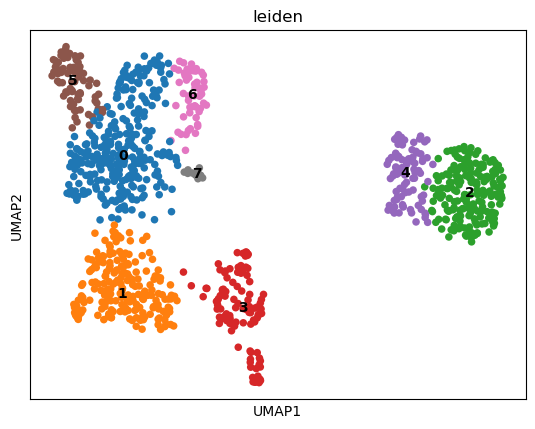

In [32]:
# Cells identified as neurons can be put into their own annotated object.
neuron_adata = adata[adata.obs['cell_type'] == 'neuron'].copy()

# Some cells have no canonical expression. Mark them as such
neuron_adata.obs['canonical_markers_present'] = (
    neuron_adata.obs['total_counts_canonical_neuronal'] > 0
).astype(str)

# Before reclustering, reset adata.X to the raw layer for subsequent steps
neuron_adata.X = neuron_adata.layers['raw'].copy()

# Recluster both anndata objects
neuron_adata = sc_utils.cluster_anndata(
    adata=neuron_adata,
    n_neighbors=15,
    leiden_resolution=0.5,
    not_highly_variable=not_highly_variable,
    obs_keys_legend_off_data=[
        'dataset',
        'total_counts_glutamatergic',
        'pct_counts_glutamatergic',
        'canonical_markers_present',
    ],
)

Sub-cluster 1 with old neighborhood graph:


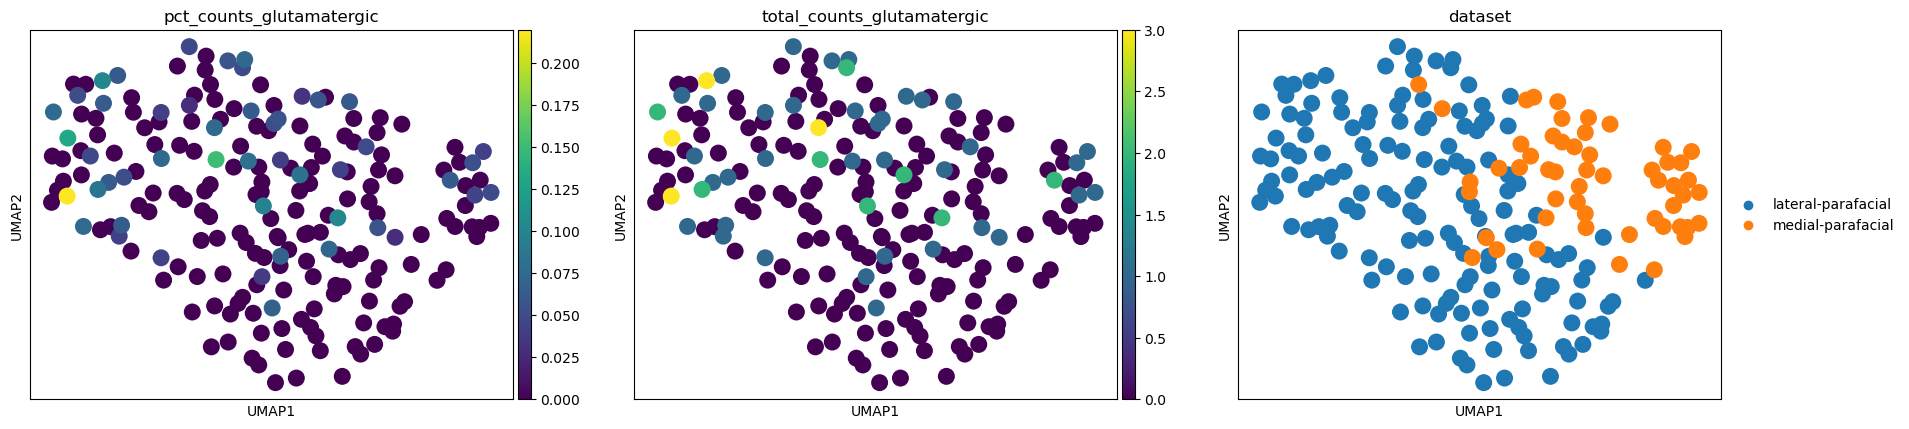

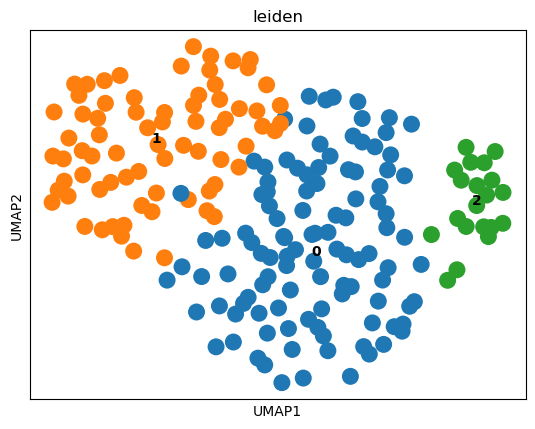

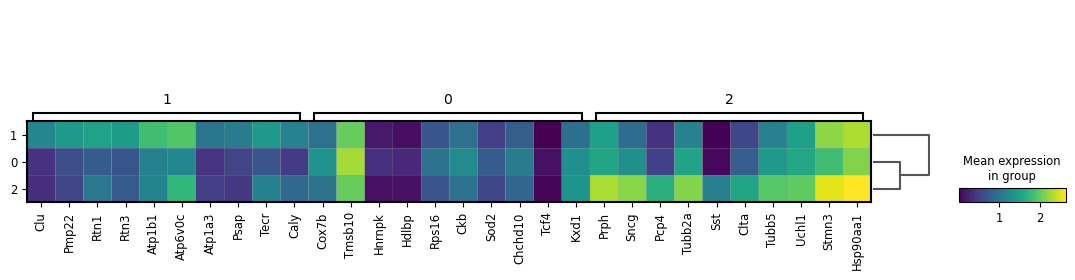

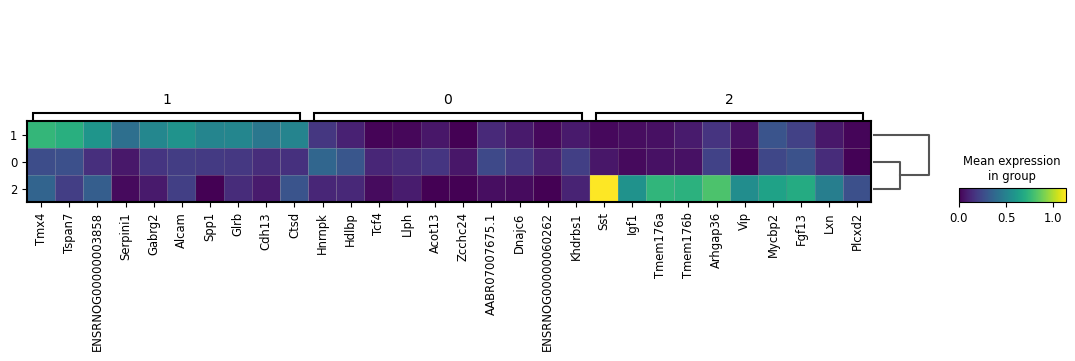

Sub-cluster 1 with new neighborhood graph:


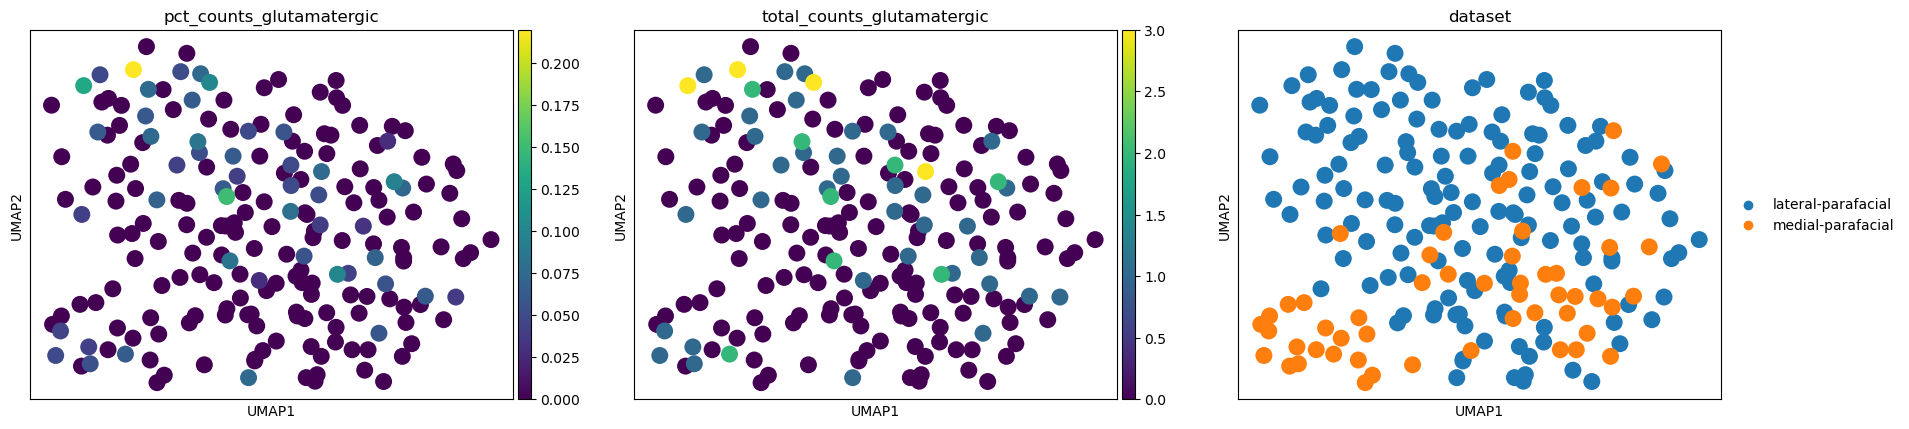

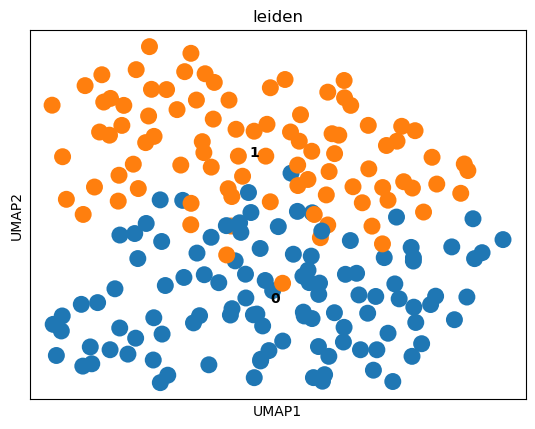

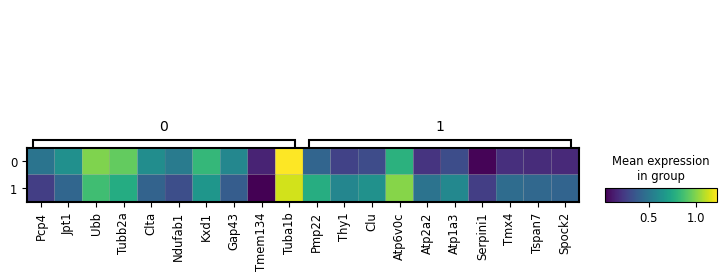

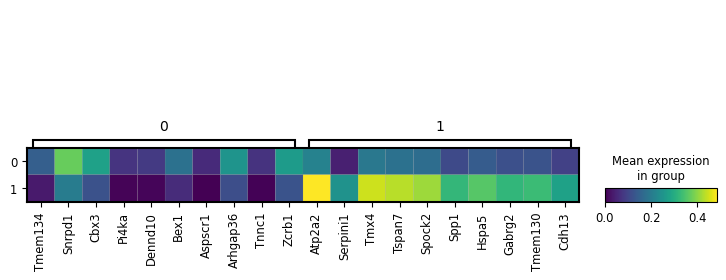

Sub-cluster 4 with old neighborhood graph:


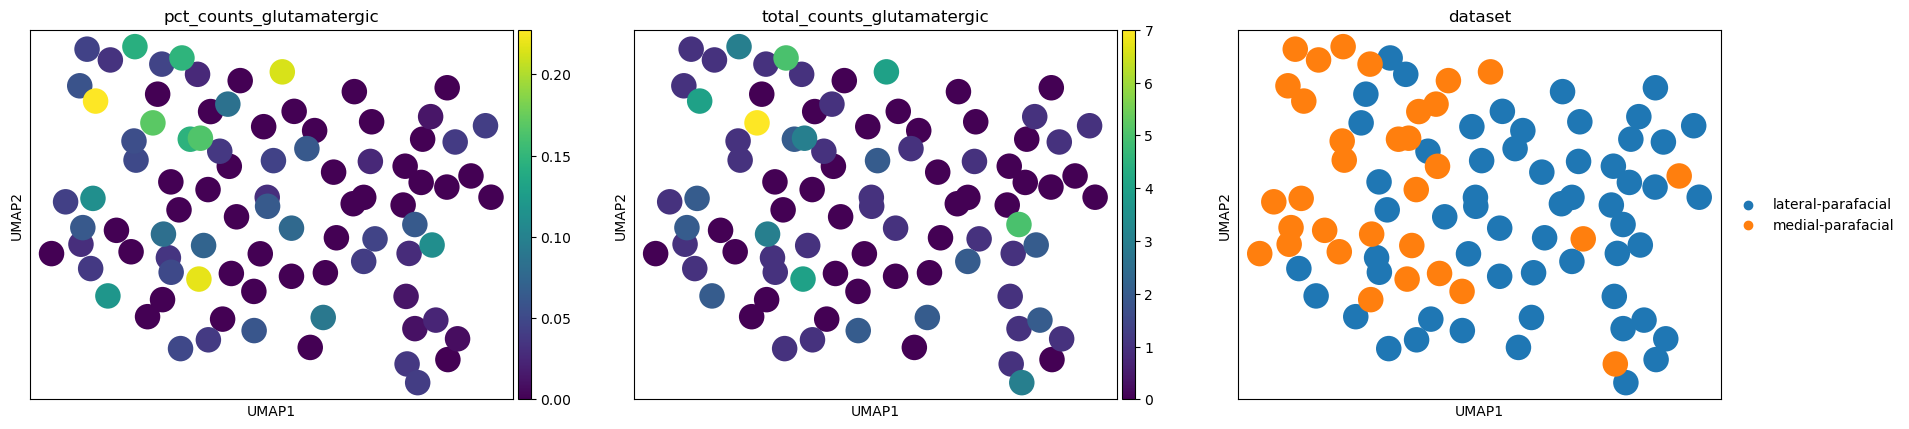

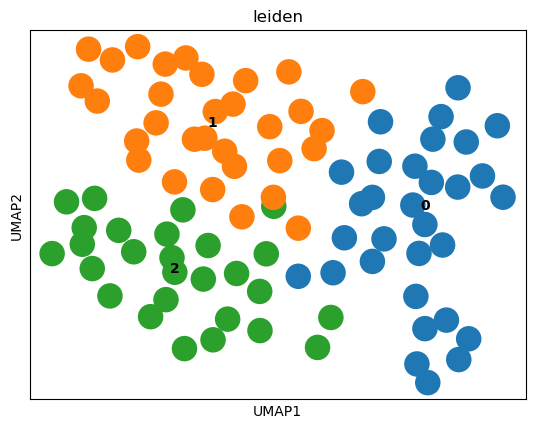

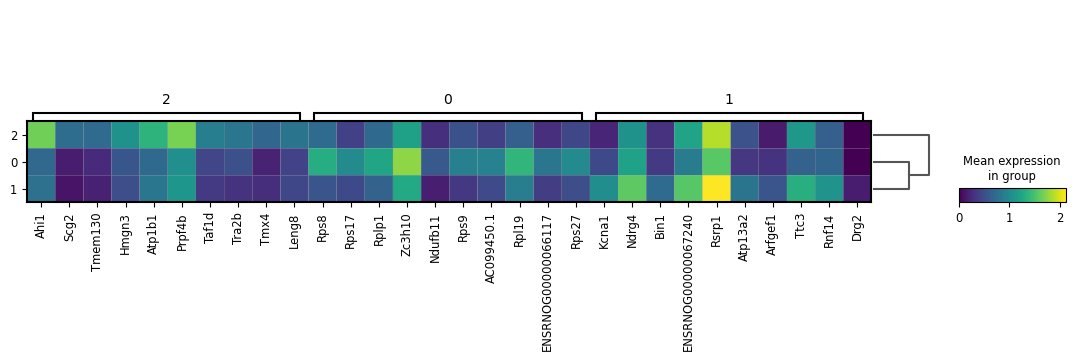

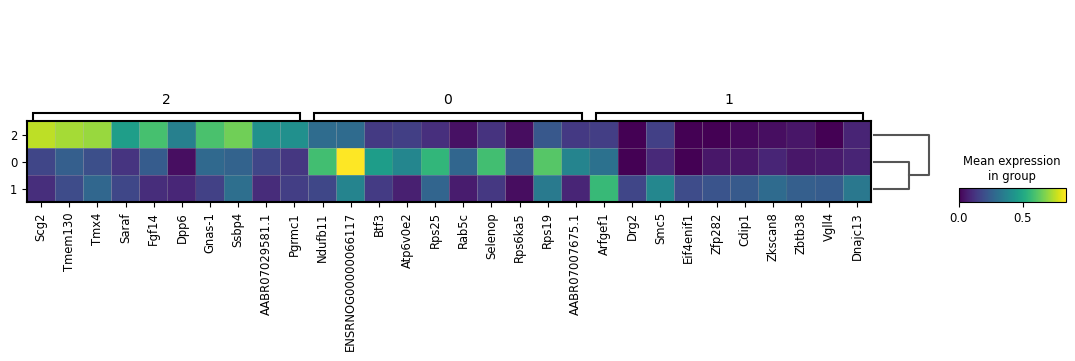

Sub-cluster 4 with new neighborhood graph:


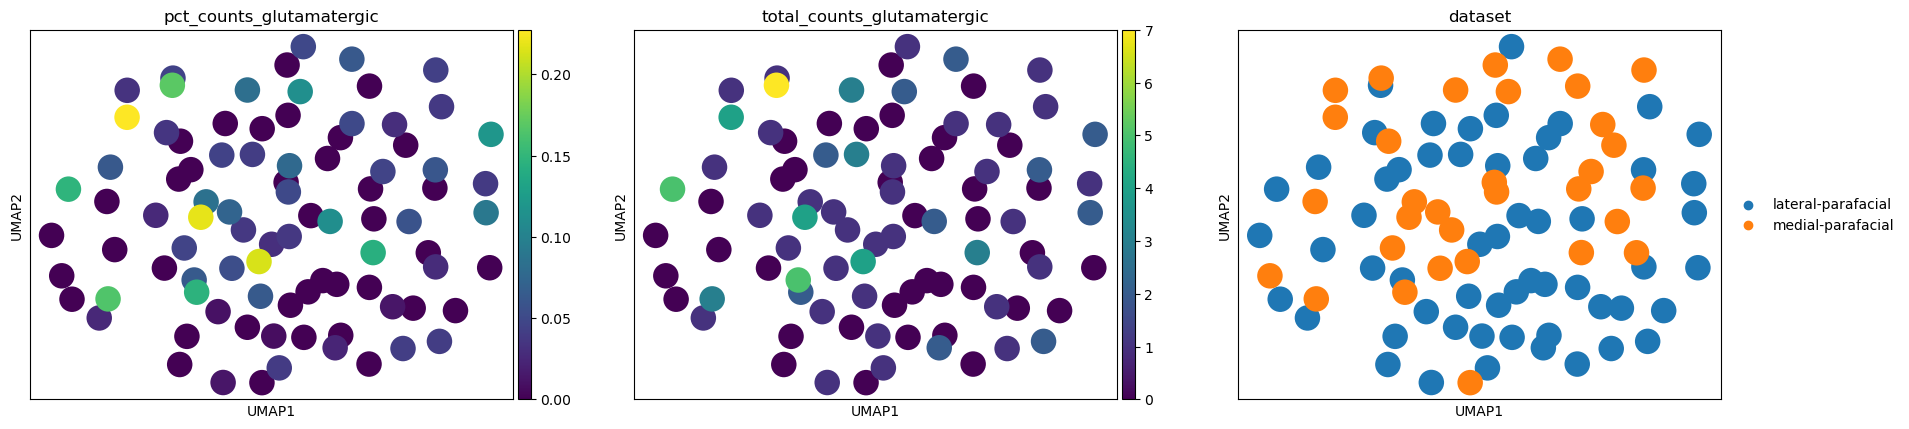

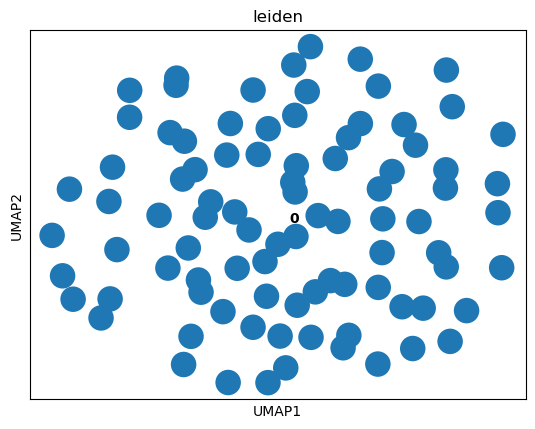

In [34]:
# In this neuronal subset, recluster clusters 2 and 3. Do it once with the current neighborhood graph, and once with a new one
neuron_sub_clusters = (neuron_adata[neuron_adata.obs['leiden'] == sub_cluster].copy()
    for sub_cluster in ('1', '4'))

graph_strs = {True: 'old', False: 'new'}
for adata in neuron_sub_clusters:
    sub_cluster = np.unique(adata.obs_vector('leiden'))[0]

    # Reset .X attribute to raw layer
    adata.X = adata.layers['raw'].copy()

    # Some genes are not expressed at all, filter them out for subsequent analysis
    sc.pp.filter_genes(adata, min_cells=1)

    for use_exist, graph_str in graph_strs.items():
        # Perform clustering analysis with existing neighborhood graph
        print(f'Sub-cluster {sub_cluster} with {graph_str} neighborhood graph:')
        adata = sc_utils.cluster_anndata(
            adata=adata,
            not_highly_variable=not_highly_variable,
            leiden_resolution=0.5,
            obs_keys_legend_off_data=[
                'pct_counts_glutamatergic',
                'total_counts_glutamatergic',
                'dataset',
            ],
            use_existing_neighbors=use_exist,
        )
        try:
            # Rank marker genes and plot without filtering
            sc.tl.rank_genes_groups(adata, groupby='leiden')
            sc.pl.rank_genes_groups_matrixplot(adata)

            # Filter marker genes
            sc.tl.filter_rank_genes_groups(
                adata, groupby='leiden', min_in_group_fraction=0.1, max_out_group_fraction=0.4
            )
            sc.pl.rank_genes_groups_matrixplot(adata, key='rank_genes_groups_filtered')
        except:
            pass
        # Writing these files doesn't currently work due to some type conversion error. To be fixed
        # sc.write(
        #     f'write/neuron_subcluster{sub_cluster}_{graph_str}_neighborhood.h5ad',
        #     adata,
        # )